## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import random
import math

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in list(zip(data_fls, ref_fls))[:]:
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric 
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    '''Given a sample data file with PPG and 3 accelerometer channels and reference file with ground truth heart rates,
       compute pulse rates every two seconds.
       Parameters:
           data_fl: .mat file containing PPG and X, Y, Z accelerometer data from Troika dataset
           ref_fl: .mat file containing ground truth heart rates from Troika dataset
       
       Returns:
           errors: numpy array with differences between predicted and reference heart rates
           confidence: numpy array with confidence values for heart rate predictions
    '''
    # Load data using LoadTroikaDataFile
    
    Fs = 125 # Troika data has sampling rate of 125 Hz
    
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    winSize = 8*Fs # Ground truth BPM provided in 8 second windows
    winShift = 2*Fs # Successive ground truth windows overlap by 2 seconds
    
    ref = sp.io.loadmat(ref_fl)
    
    errs = []
    confs = []
    
    # For each 8 second window, compute a predicted BPM and confidence and compare to ground truth
    offset = 0
    for eval_window_idx in range(len(ref['BPM0'])):
        
        # Set verbose to True to visualize plot analysis
        verbose = False
        # verbose = True if eval_window_idx == 28 else False
    
        window_start = offset
        window_end = winSize+offset
        offset += winShift
        
        if verbose:
            print(f"Win start,end: {window_start}, {window_end}")
        
        ppg_window = ppg[window_start:window_end]
        accx_window = accx[window_start:window_end]
        accy_window = accy[window_start:window_end]
        accz_window = accz[window_start:window_end]

        pred, conf = AnalyzeWindow(ppg_window, accx_window, accy_window, accz_window, Fs=Fs, verbose=verbose)
        
        groundTruthBPM = ref['BPM0'][eval_window_idx][0]
        if verbose:
            print('Ground Truth BPM: ', groundTruthBPM)

        predError = groundTruthBPM - pred
        errs.append(predError)
        confs.append(conf)

    errors, confidence = np.array(errs), np.array(confs)
    return errors, confidence

def AnalyzeWindow(ppg, accx, accy, accz, Fs=125, verbose=False):
    ''' Analyze a single 8 second window of PPG and Accelerometer data.
        Parameters:
            ppg: numpy array with ppg values
            accx/y/z: numpy arrays with per-axis accelerometer data
            Fs: sampling rate used by both PPG and accelerometer sensors
            verbose: display plots and logging information.
    
        Returns:
            prediction: Tuple of (BPM prediction, confidence) for this window.
    '''
    
    ppg_bandpass = BandpassFilter(ppg, fs=Fs)
    accx_bandpass = BandpassFilter(accx, fs=Fs)
    accy_bandpass = BandpassFilter(accy, fs=Fs)
    accz_bandpass = BandpassFilter(accz, fs=Fs)
    
    # Aggregate accelerometer data into single signal
    
    accy_mean = accy-np.mean(accy_bandpass) # Center Y values
    acc_mag_unfiltered = np.sqrt(accx_bandpass**2+accy_mean**2+accz_bandpass**2)
    acc_mag = BandpassFilter(acc_mag_unfiltered, fs=Fs)
    
    peaks = find_peaks(ppg_bandpass, height = 10, distance=35)[0]
    
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
        ax1.title.set_text('Signal with Time Domain FindPeaks()')
        ax1.plot(ppg_bandpass)
        ax1.plot(peaks, ppg_bandpass[peaks], "x")
        
        ax2.title.set_text('Aggregated Accelerometer Data')
        ax2.plot(acc_mag, color="purple")
        plt.show()
        
    # Use FFT length larger than the input signal size for higher spectral resolution.
    fft_len=len(ppg_bandpass)*4

    # Create an array of frequency bins
    freqs = np.fft.rfftfreq(fft_len, 1 / Fs) # bins of width 0.12207031

    # The frequencies between 40 BPM and 240 BPM Hz
    low_freqs = (freqs >= (40/60)) & (freqs <= (240/60))
    
    mag_freq_ppg, fft_ppg = FreqTransform(ppg_bandpass, freqs, low_freqs, fft_len)
    mag_freq_acc, fft_acc = FreqTransform(acc_mag, freqs, low_freqs, fft_len)
    
    peaks_ppg = find_peaks(mag_freq_ppg, height=30, distance=1)[0]
    peaks_acc = find_peaks(mag_freq_acc, height=30, distance=1)[0]
    
    # Sort peaks in order of peak magnitude
    sorted_freq_peaks_ppg = sorted(peaks_ppg, key=lambda i:mag_freq_ppg[i], reverse=True)
    sorted_freq_peaks_acc = sorted(peaks_acc, key=lambda i:mag_freq_acc[i], reverse=True)
    
    # Use the frequency peak with the highest magnitude, unless the peak is also present in the accelerometer peaks.
    use_peak = sorted_freq_peaks_ppg[0]
    for i in range(len(sorted_freq_peaks_ppg)):
        # Check nearest two peaks also
        cond1 = sorted_freq_peaks_ppg[i] in sorted_freq_peaks_acc
        cond2 = sorted_freq_peaks_ppg[i]-1 in sorted_freq_peaks_acc
        cond3 = sorted_freq_peaks_ppg[i]+1 in sorted_freq_peaks_acc
        if cond1 or cond2 or cond3:
            continue
        else:
            use_peak = sorted_freq_peaks_ppg[i]
            break

    chosen_freq = freqs[low_freqs][use_peak]
    prediction = chosen_freq * 60
    confidence = CalcConfidence(chosen_freq, freqs, fft_ppg)
    
    if verbose:
        plt.title("PPG Frequency Magnitude")
        plt.plot(mag_freq_ppg)
        plt.plot(peaks_ppg, mag_freq_ppg[peaks_ppg], "x")
        plt.show()
        
        plt.title("ACC Frequency Magnitude")
        plt.plot(mag_freq_acc, color="purple")
        plt.plot(peaks_acc, mag_freq_acc[peaks_acc], "x")
        plt.show()
        
        print("PPG Freq Peaks: ", peaks_ppg)
        print("ACC Freq Peaks: ", peaks_acc)
        
        print("PPG Freq Peaks Sorted: ", sorted_freq_peaks_ppg)
        print("ACC Freq Peaks Sorted: ", sorted_freq_peaks_acc)
        print("Use peak: ", use_peak)
        print(f"Predicted BPM: {prediction}, {chosen_freq} (Hz), Confidence: {confidence}")        
        
    return (prediction, confidence)

def BandpassFilter(signal, fs):
    '''Bandpass filter the signal between 40 and 240 BPM'''
    
    # Convert to Hz
    lo, hi = 40/60, 240/60
    
    b, a = sp.signal.butter(3, (lo, hi), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def FreqTransform(x, freqs, low_freqs, fft_len):
    '''Compute and return FFT and magnitude of FFT for given low frequencies
        Parameters:
            x: numpy array input signal to transform
            freqs: full list of FFT frequency bins
            low_freqs: low frequency bins between 40 BPM and 240 BPM
            fft_len: length of FFT to compute
            
        Returns:
            mag_freq_x: magnitude of lower frequencies of the FFT transformed signal
            fft_x: FFT of normalized input signal
    '''
    
    # Take an FFT of the normalized signal
    norm_x = (x - np.mean(x))/(max(x)-min(x))
    fft_x = np.fft.rfft(norm_x, fft_len)

    # Calculate magnitude of the lower frequencies
    mag_freq_x = np.abs(fft_x)[low_freqs]
    
    return mag_freq_x, fft_x

def CalcConfidence(chosen_freq, freqs, fft_ppg):
    '''Calculates a confidence value for a given frequency by computing
       the ratio of energy concentrated near that frequency compared to the full signal.
       Parameters:
           chosen_freq: frequency prediction for heart rate.
           freqs: full list of FFT frequency bins
           fft_ppg: FFT of normalized PPG signal
       
       Returns:
           conf_val: Confidence value for heart rate prediction.
    '''
    win = (40/60.0)
    win_freqs = (freqs >= chosen_freq - win) & (freqs <= chosen_freq + win)
    abs_fft_ppg = np.abs(fft_ppg)
    
    # Sum frequency spectrum near pulse rate estimate and divide by sum of entire spectrum
    conf_val = np.sum(abs_fft_ppg[win_freqs])/np.sum(abs_fft_ppg)
    
    return conf_val

In [2]:
MAE = Evaluate()
print("=====\n", "MAE is: ", MAE)

=====
 MAE is:  13.6253624128


#### Analyze Single Window of PPG and Accelerometer Data

Win start,end: 5000, 6000


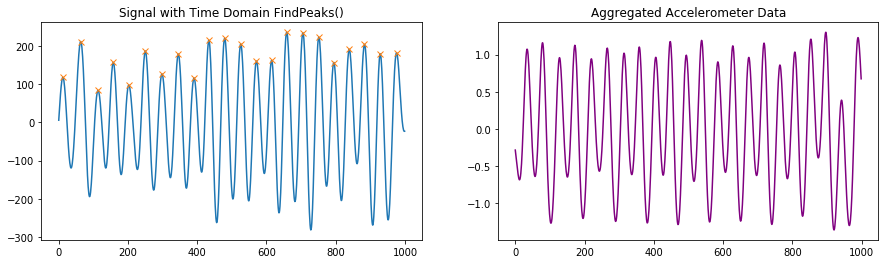

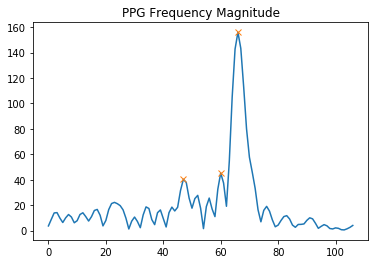

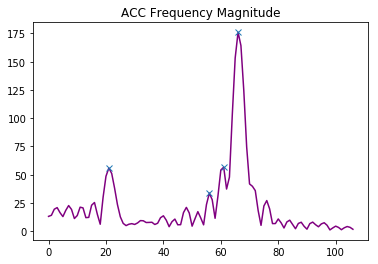

PPG Freq Peaks:  [47 60 66]
ACC Freq Peaks:  [21 56 61 66]
PPG Freq Peaks Sorted:  [66, 60, 47]
ACC Freq Peaks Sorted:  [66, 61, 21, 56]
Use peak:  47
Predicted BPM: 129.375, 2.15625 (Hz), Confidence: 0.5644915855476166
Ground Truth BPM:  130.3592
Prediction Error:  0.9842


In [6]:
# Single Window Test

data_fls, ref_fls = LoadTroikaDataset()

# CHOOSE FILE
file_num = 10

data_fl, ref_fl = list(zip(data_fls, ref_fls))[file_num:file_num+1][0]

# Load data using LoadTroikaDataFile
Fs = 125 # Troika data has sampling rate of 125 Hz
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ref = sp.io.loadmat(ref_fl)

winSize = 8*Fs # Ground truth BPM provided in 8 second windows
winShift = 2*Fs # Successive ground truth windows overlap by 2 seconds

# CHOOSE WINDOW IN FILE
eval_window_idx = 20

offset = eval_window_idx*winShift

window_start = offset
window_end = winSize+offset
offset += winShift

print(f"Win start,end: {window_start}, {window_end}")
ppg_window = ppg[window_start:window_end]

accx_window = accx[window_start:window_end]
accy_window = accy[window_start:window_end]
accz_window = accz[window_start:window_end]

pred, conf = AnalyzeWindow(ppg_window, accx_window, accy_window, accz_window, Fs=Fs, verbose=True)

groundTruthBPM = ref['BPM0'][eval_window_idx][0]
print('Ground Truth BPM: ', groundTruthBPM)

predError = groundTruthBPM - pred
print("Prediction Error: ", predError)

## PROJECT WRITE UP

##### CODE DESCRIBTION

The code in this notebook can be used in two ways:

##### 1) To analyze algorithm performance on Troika dataset.

The function RunPulseRateAlgorithm() expects two files as input:

data_fl: .mat file containing PPG and X, Y, Z accelerometer data from Troika dataset (or in Troika format)
ref_fl: .mat file containing ground truth heart rates from Troika dataset (or in Troika format)
RunPulseRateAlgorithm() will compute the heart rate and confidence estimates for 8 second windows of the PPG and accelerometer data, and calculate the error (difference) between the heart estimates and the ground truth heart rate for each 8 second window provided in the reference file.

The function Evaluate() will calculate an overall mean absolute error at 90% availability (see Algorithm Performance section below), assuming the Troika data is located at ./datasets/troika/training_data.

##### 2) To predict heart rate from new input PPG and Accelerometer data.

The function AnalyzeWindow() accepts numpy arrays of ppg, and accelerometer data in the x, y, and z axis, along with a sampling rate. A precondition of the function is that the incoming ppg and acceleromter data was sampled at the provided sampling rate and is aligned in time. While the algorithm was only tested with 8 second windows of PPG and accelerometer data and a sampling rate of 125 Hz, the AnalyzeWindow function may be applied to a longer window sizes or alternate sampling rates. AnalyzeWindow() returns a tuple of (BPM prediction, confidence) for the provided window of ppg and accelerometer data using the provided sample rate.

##### DATA DESCRIBTION

TROIKA dataset includes 12 subjects ages 18 to 35 with simultaneously recorded two-channel wrist-mounted PPG signals, wrist-mounted three-axis accelerometer signals, and one-channel chest-mounted ECG. The subjects ran on a treadmill at increasing rates to range from resting heart rate to intense exercise heart rate. To build a more complete dataset, it would be beneficial to include a greater number of participants that represent the broader population demographics for age and gender. Additionally, it would be useful to record PPG and accelerometer data from more points on the body that could be used in future wearable devices such as the feet, legs, upper arms, and head. This could provide a more complete picture of how accelerometer signals affect PPG data across the body. Alternative exercises could be recorded as well, such as cylcing, swimming, tennis, and weight lifting, each of which may produce different physiological responses or signal patterns.

##### ALGORITHM DESCRIBTION

Pulse rate estimation algorithm takes advantage of the physiology of blood flow through the ventricles of the wrist. Light emitted by an LED on the PPG sensor is reflected less when the ventricles contract and more blood is present, and light is reflected more when the blood returns to the heart and fewer red blood cells are present. Arm movement will also affect the blood levels in the wrist, so periodic motion such as an arm swinging back and forth can also be detected by the PPG signal.

The algorithm identifies the strongest frequency components of both the PPG signal and the accelerometer signals to determine which frequency to pick as the heart rate. The algorithm follows these stages:

1) Apply bandpass filter to PPG and accelerometer signals to filter out frequencies outside of the 40-240 BPM range.

2) Aggregate the X, Y, and Z channels of the accelerometer signal into a signal magnitude signal.

3) Tranform the time domain PPG and accelerometer signal to magnitude frequency representations by taking the absolute value of their Fast Fourier Transforms.

4) Using the frequency representations of PPG and accelerometer signals, find the peaks with the largest magnitudes, and choose one to be the predicted heart rate frequency.

If the highest magnitude peak of both signals is different, choose the highest magnitude peak of the the PPG signal as the heart rate frequency prediction.
If the highest magnitude peak of both signals is the same, this may mean that the arm swing signal is overpowering the pulse rate, so choose the next highest magnitude peak of the PPG signal as the heart rate frequency prediction.
If each of the highest magnitude peaks of the PPG signal are too close to the peaks of the accelerometer signal, the arm swing frequency could be the same as the pulse rate frequency, so use the highest magnitude peak of the PPG as the heart rate frequency prediction, even though the accelerometer signal has the same peak).

5) Convert the chosen peak frequency to a final BPM Prediction, and calculate a Confidence Value for the chosen frequency by computing the ratio of energy concentrated near that frequency compared to the full signal.

The BPM Prediction and Confidence Value outputs from this algorithm are not gauranteed to be correct. Confidence values are only used to determine which outputs are very poor, i.e. a low confidence value implies very low signal to noise ratio, since only a small amount of energy is concentrated by the predicted peak. High confidence values do not necessarily imply the that algorithm is significantly more correct, only that the peak at that location is responsible for much more of the signal. Common failure modes include when accelerometer data has random movement spikes or when the three channels combine into a non-periodic signal.

##### ALGORITHM PERFORMANCE

The algorithm performance was evaluated against the TROIKA reference data. All PPG data was compared against ECG "ground truth" BPM for associated time windows. ECG measures electric potentials across the heart and is considered to be a much more reliable method for obtaining pulse rate than PPG since these electrical signals are not susceptible to the same levels of movement-related noise. Using the confidence estimates to compare prediction quality, the bottom 10% of predictions were discarded while the remaining predictions were evaluated against the ground truth. The final calculated performance metric for the dataset at 90% availability was a mean absolute error (MAE) of 13.625 BPM. This performance may be verified by executing the Evaluate() function.

This algorithm may not perform as well at >90% availability, and does not gaurantee that consecutive or overlapping time windows have similar confidence values, so it is possible that prediction confidence could vary greatly over time if this algorithm was applied to a real-time heart rate analysis scenario. This algorithm also assumes that accelerometer motion will largely result from swinging arms during running on a treadmill and will therefore be consistently periodic. This may not be the case for other activities, such as tennis or basketball.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 